In [62]:
import sys
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd().parent / 'scripts'))
from _helpers import to_date_period

idx = pd.IndexSlice

path = Path.cwd().parent / 'results' / 'periods'

In [74]:
dr = pd.date_range('2024-03-18', '2024-03-25', freq='30min')

In [75]:
cols = pd.MultiIndex.from_product(
    (('nodal', 'eso', 'national'),
    ('wholesale', 'balancing', 'cfd', 'congestion_rent'))
)

In [76]:
results = pd.DataFrame(
    columns=cols,
    index=dr,
    )

for ts in tqdm(results.index):
    date, period = to_date_period(ts)

    with open(path / f'{date}_{period}.json') as f:
        data = json.load(f)

    assert list(data)[0] == str(int(ts.timestamp()))

    for l, quant in results.columns:

        getname = quant + '_cost' if not 'congestion' in quant else quant
        results.loc[ts, idx[l, quant]] = data[list(data)[0]][l]['globals']['variables'][getname]


  0%|          | 0/337 [00:00<?, ?it/s]

100%|██████████| 337/337 [00:10<00:00, 32.78it/s]


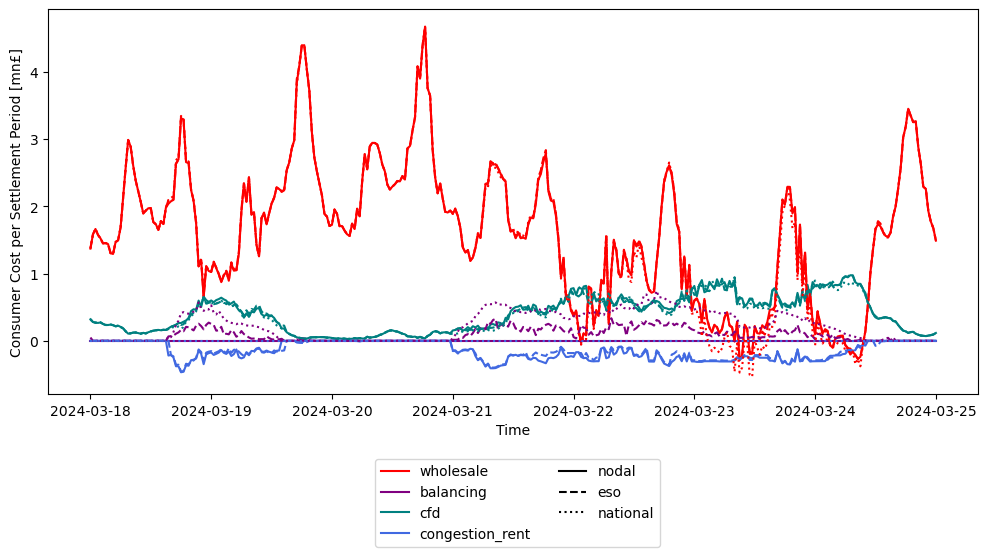

In [77]:
results

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

cmapper = {
    'wholesale': 'r',
    'balancing': 'purple',
    'cfd': 'teal',
    'congestion_rent': 'royalblue',
}
lmapper = {
    'nodal': '-',
    'eso': '--',
    'national': ':',
}

lw = 1.5

for l, q in results.columns:
    ax.plot(results.index, results.loc[:, idx[l, q]].mul(1e-6), linestyle=lmapper[l], color=cmapper[q], lw=lw)

# for l, ls in lmapper.items():
#     ax.plot(results.index, results.loc[:, idx[l,:]].sum(axis=1).mul(1e-6), linestyle=ls, color='grey', lw=lw)

handles, labels = [], []

from matplotlib.lines import Line2D

for l, c in cmapper.items():
    handles.append(Line2D([0], [0], color=c, lw=lw, ls='-'))
    labels.append(l)

# handles.append(Line2D([0], [0], color='grey', lw=lw, ls='-'))
# labels.append('Total')

for l, ls in lmapper.items():
    handles.append(Line2D([0], [0], color='k', lw=lw, ls=ls))
    labels.append(l)

# handles.append(plt.Line2D([0], [0], color=c, lw=lw, linestyle='-'))

ax.legend(
    handles,
    labels,
    ncol=2,
    bbox_to_anchor=(0.665, -0.15),
)
ax.set_ylabel('Consumer Cost per Settlement Period [mn£]')
ax.set_xlabel('Time')

plt.show()